In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


91884032/91884032 [==============================] - 5s 0us/step
Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 149, 149, 32  128        ['block1_conv1[0][0]']           
 ation)                   

<ipython-input-2-ffd0d1fd670b>:65: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet=cm.get_cmap("jet") # [0,255] 열지도를 jet 컬러맵으로 표시함


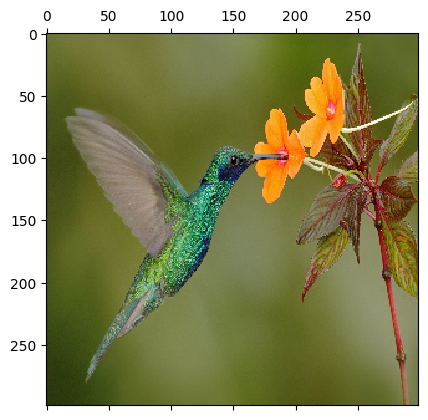

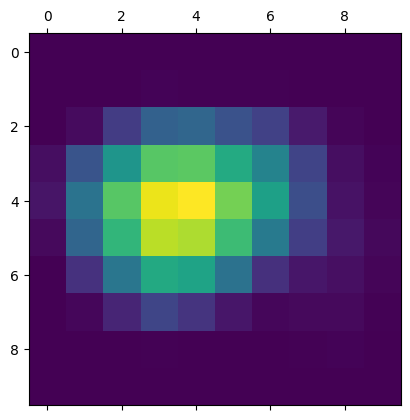

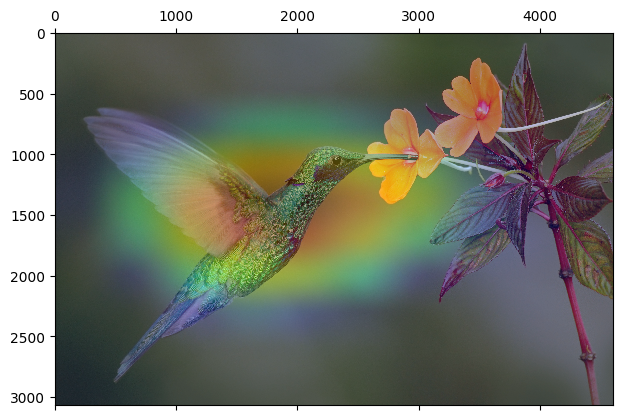

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import xception
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# 사전 학습된 신경망 모델을 불러오고 신경망 구조를 확인
model=xception.Xception(weights='imagenet')
model.summary()

# 지정된 영상을 불러와 크기를 조정하고 화면에 디스플레이
image_path='/content/drive/MyDrive/CodeData/GitHub_Examples/XAI_DT_CAM_hummingbird.jpg'
img=image.load_img(image_path,target_size=(299,299))
plt.matshow(img)

# 영상을 신경망 입력 형태로 변환
x=image.img_to_array(img)
x=np.expand_dims(x,axis=0)
x=xception.preprocess_input(x)

# 인식을 시도하고 top-5 결과를 출력
preds = model.predict(x)
print("예측 결과:", xception.decode_predictions(preds,top=5)[0])

# 신경망 모델의 특징 추출(컨볼루션층) 부분에서 마지막 층을 지정
# 특징 추출 부분만으로 구성된 모델 model_1 만들기
last_conv_layer=model.get_layer("block14_sepconv2_act")

model_1=keras.Model(model.inputs,last_conv_layer.output)

# 분류(전역평균 풀링 또는 완전연결 층) 부분만으로 구성된 모델 model_2 만들기
input_2=keras.Input(shape=last_conv_layer.output.shape[1:])
x_2=model.get_layer("avg_pool")(input_2)
x_2=model.get_layer("predictions")(x_2)
model_2=keras.Model(input_2,x_2)

# GradientTape 함수를 이용한 그레이디언트 계산
with tf.GradientTape() as tape:
    output_1=model_1(x)
    tape.watch(output_1) # 마지막 층으로 미분하기 위한 준비
    preds=model_2(output_1)
    class_id=tf.argmax(preds[0])
    output_2=preds[:,class_id]

grads=tape.gradient(output_2,output_1) # 그레이디언트 계산
pooled_grads=tf.reduce_mean(grads,axis=(0,1,2))

output_1=output_1.numpy()[0]
pooled_grads=pooled_grads.numpy()
for i in range(pooled_grads.shape[-1]):
    output_1[:,:,i]*=pooled_grads[i]
heatmap=np.mean(output_1,axis=-1)

heatmap=np.maximum(heatmap,0)/np.max(heatmap) # [0,1]로 정규화
plt.matshow(heatmap)

# 열지도를 입력 영상에 덧씌움
img=image.load_img(image_path) # 입력 영상을 다시 받아옴

img=image.img_to_array(img)
heatmap=np.uint8(255*heatmap) # [0,255]로 변환

jet=cm.get_cmap("jet") # [0,255] 열지도를 jet 컬러맵으로 표시함
color=jet(np.arange(256))[:,:3]
color_heatmap=color[heatmap]

color_heatmap=keras.preprocessing.image.array_to_img(color_heatmap)
color_heatmap=color_heatmap.resize((img.shape[1],img.shape[0]))
color_heatmap=keras.preprocessing.image.img_to_array(color_heatmap)

overlay_img=color_heatmap*0.4+img # 덧씌움
overlay_img=keras.preprocessing.image.array_to_img(overlay_img)
plt.matshow(overlay_img)

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 149, 149, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 149, 149, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                          

<ipython-input-3-43ca793c3391>:65: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet=cm.get_cmap("jet") # [0,255] 열지도를 jet 컬러맵으로 표시함


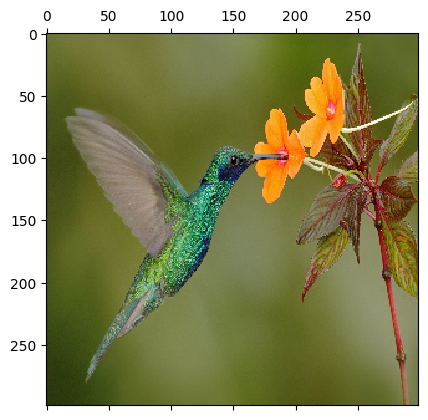

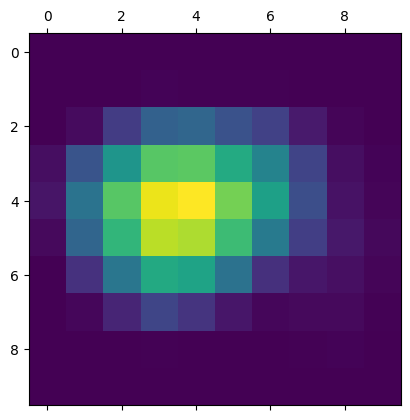

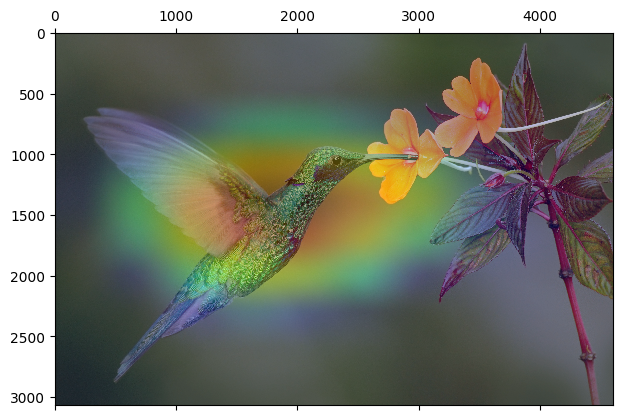

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import xception
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# 사전 학습된 신경망 모델을 불러오고 신경망 구조를 확인
model=xception.Xception(weights='imagenet')
model.summary()

# 지정된 영상을 불러와 크기를 조정하고 화면에 디스플레이
image_path='/content/drive/MyDrive/CodeData/GitHub_Examples/XAI_DT_CAM_hummingbird.jpg'
img=image.load_img(image_path,target_size=(299,299))
plt.matshow(img)

# 영상을 신경망 입력 형태로 변환
x=image.img_to_array(img)
x=np.expand_dims(x,axis=0)
x=xception.preprocess_input(x)

# 인식을 시도하고 top-5 결과를 출력
preds = model.predict(x)
print("예측 결과:", xception.decode_predictions(preds,top=5)[0])

# 신경망 모델의 특징 추출(컨볼루션층) 부분에서 마지막 층을 지정
# 특징 추출 부분만으로 구성된 모델 model_1 만들기
last_conv_layer=model.get_layer("block14_sepconv2_act")

model_1=keras.Model(model.inputs,last_conv_layer.output)

# 분류(전역평균 풀링 또는 완전연결 층) 부분만으로 구성된 모델 model_2 만들기
input_2=keras.Input(shape=last_conv_layer.output.shape[1:])
x_2=model.get_layer("avg_pool")(input_2)
x_2=model.get_layer("predictions")(x_2)
model_2=keras.Model(input_2,x_2)

# GradientTape 함수를 이용한 그레이디언트 계산
with tf.GradientTape() as tape:
    output_1=model_1(x)
    tape.watch(output_1) # 마지막 층으로 미분하기 위한 준비
    preds=model_2(output_1)
    class_id=tf.argmax(preds[0])
    output_2=preds[:,class_id]

grads=tape.gradient(output_2,output_1) # 그레이디언트 계산
pooled_grads=tf.reduce_mean(grads,axis=(0,1,2)) # 식 (12.5) 적용

output_1=output_1.numpy()[0]
pooled_grads=pooled_grads.numpy()
for i in range(pooled_grads.shape[-1]): # 식 (12.6) 적용
    output_1[:,:,i]*=pooled_grads[i]
heatmap=np.mean(output_1,axis=-1)

heatmap=np.maximum(heatmap,0)/np.max(heatmap) # [0,1]로 정규화
plt.matshow(heatmap)

# 열지도를 입력 영상에 덧씌움
img=image.load_img(image_path) # 입력 영상을 다시 받아옴

img=image.img_to_array(img)
heatmap=np.uint8(255*heatmap) # [0,255]로 변환

jet=cm.get_cmap("jet") # [0,255] 열지도를 jet 컬러맵으로 표시함
color=jet(np.arange(256))[:,:3]
color_heatmap=color[heatmap]

color_heatmap=keras.preprocessing.image.array_to_img(color_heatmap)
color_heatmap=color_heatmap.resize((img.shape[1],img.shape[0]))
color_heatmap=keras.preprocessing.image.img_to_array(color_heatmap)

overlay_img=color_heatmap*0.4+img # 덧씌움
overlay_img=keras.preprocessing.image.array_to_img(overlay_img)
plt.matshow(overlay_img)